In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-37tsfy_p
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-37tsfy_p


In [2]:
dataset_name = "monet2photo"
#dataset_name = "summer2winter_yosemite"

In [3]:
!wget "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{dataset_name}.zip"
!unzip "{dataset_name}.zip" -d "{dataset_name}"

Streaming output truncated to the last 5000 lines.
  inflating: monet2photo/monet2photo/trainB/2016-03-31 05:58:36.jpg  
  inflating: monet2photo/monet2photo/trainB/2014-01-10 12:46:39.jpg  
  inflating: monet2photo/monet2photo/trainB/2015-02-23 11:45:00.jpg  
  inflating: monet2photo/monet2photo/trainB/2015-05-23 09:38:08.jpg  
  inflating: monet2photo/monet2photo/trainB/2016-01-15 00:48:49.jpg  
  inflating: monet2photo/monet2photo/trainB/2016-12-27 18:15:26.jpg  
  inflating: monet2photo/monet2photo/trainB/2017-01-02 11:16:05.jpg  
  inflating: monet2photo/monet2photo/trainB/2015-08-06 11:08:32.jpg  
  inflating: monet2photo/monet2photo/trainB/2015-12-16 07:43:36.jpg  
  inflating: monet2photo/monet2photo/trainB/2016-03-25 12:57:28.jpg  
  inflating: monet2photo/monet2photo/trainB/2016-05-10 11:44:44.jpg  
  inflating: monet2photo/monet2photo/trainB/2015-03-11 08:01:52.jpg  
  inflating: monet2photo/monet2photo/trainB/2015-08-30 05:26:05.jpg  
  inflating: monet2photo/monet2photo/tr

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [5]:
# import glob
# import cv2

# def load_images_dir(image_dir):
#   images = []
#   for image_path in glob.glob(image_dir):
#     image = cv2.imread(image_path)
#     images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#   return np.array(images)

In [6]:
# trainA = tf.data.Dataset.from_tensor_slices((load_images_dir(f"/content/{dataset_name}/{dataset_name}/trainA/*.jpg")))
# trainB = tf.data.Dataset.from_tensor_slices((load_images_dir(f"/content/{dataset_name}/{dataset_name}/trainB/*.jpg")))

# testA = tf.data.Dataset.from_tensor_slices((load_images_dir(f"/content/{dataset_name}/{dataset_name}/testA/*.jpg")))
# testB = tf.data.Dataset.from_tensor_slices((load_images_dir(f"/content/{dataset_name}/{dataset_name}/testB/*.jpg")))


In [7]:
dataset, metadata = tfds.load(f'cycle_gan/{dataset_name}',
                              with_info=True, as_supervised=True)

trainA, trainB = dataset['trainA'], dataset['trainB']
testA, testB = dataset['testA'], dataset['testB']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1072 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteYZ4EK8/cycle_gan-trainA.tfrecord*...:   …

Generating trainB examples...:   0%|          | 0/6287 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteYZ4EK8/cycle_gan-trainB.tfrecord*...:   …

Generating testA examples...:   0%|          | 0/121 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteYZ4EK8/cycle_gan-testA.tfrecord*...:   0…

Generating testB examples...:   0%|          | 0/751 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteYZ4EK8/cycle_gan-testB.tfrecord*...:   0…

Dataset cycle_gan downloaded and prepared to ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

In [10]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  return image

In [11]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [12]:
def preprocess_image_train(image, label=None):
  image = random_jitter(image)
  image= normalize(image)
  return image

In [13]:
def preprocess_image_test(image, label=None):
  image = normalize(image)
  return image

In [14]:
trainA = trainA.cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

trainB = trainB.cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

testA = testA.cache().map(preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

testB = testB.cache().map(preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [15]:
sample_A = next(iter(trainA))
sample_B = next(iter(trainB))

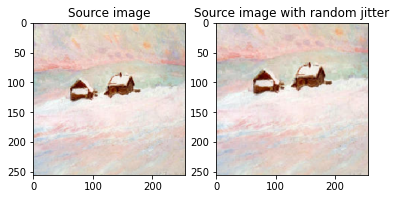

In [16]:
plt.subplot(121)
plt.title("Source image")
plt.imshow(sample_A[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Source image with random jitter")
plt.imshow(random_jitter(sample_A[0] * 0.5 + 0.5))

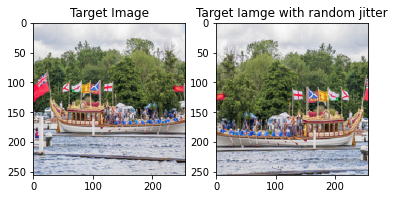

In [17]:
plt.subplot(121)
plt.title("Target Image")
plt.imshow(sample_B[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Target Iamge with random jitter")
plt.imshow(random_jitter(sample_B[0] * 0.5 + 0.5))

In [18]:
def downsample(filters, size, norm_type="batchnorm", apply_norm=True):
  initializer = tf.random_normal_initializer(0.0, 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding="same", 
                                    kernel_initializer=initializer, 
                                    use_bias=False))
  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [19]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0.0, 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, 
                                             padding="same", 
                                             kernel_initializer=initializer, 
                                             use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [20]:
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [21]:
def Generator(output_channels, norm_type):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  down_stack = [
    downsample(64, 4, apply_norm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4, norm_type),  # (batch_size, 64, 64, 128)
    downsample(256, 4, norm_type),  # (batch_size, 32, 32, 256)
    downsample(512, 4, norm_type),  # (batch_size, 16, 16, 512)
    downsample(512, 4, norm_type),  # (batch_size, 8, 8, 512)
    downsample(512, 4, norm_type),  # (batch_size, 4, 4, 512)
    downsample(512, 4, norm_type),  # (batch_size, 2, 2, 512)
    downsample(512, 4, norm_type),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0.0, 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2,
                                         padding="same",
                                         kernel_initializer=initializer,
                                         activation="tanh") # (batch_size, 256, 256, 3)
  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [22]:
def Discriminator(norm_type, target):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


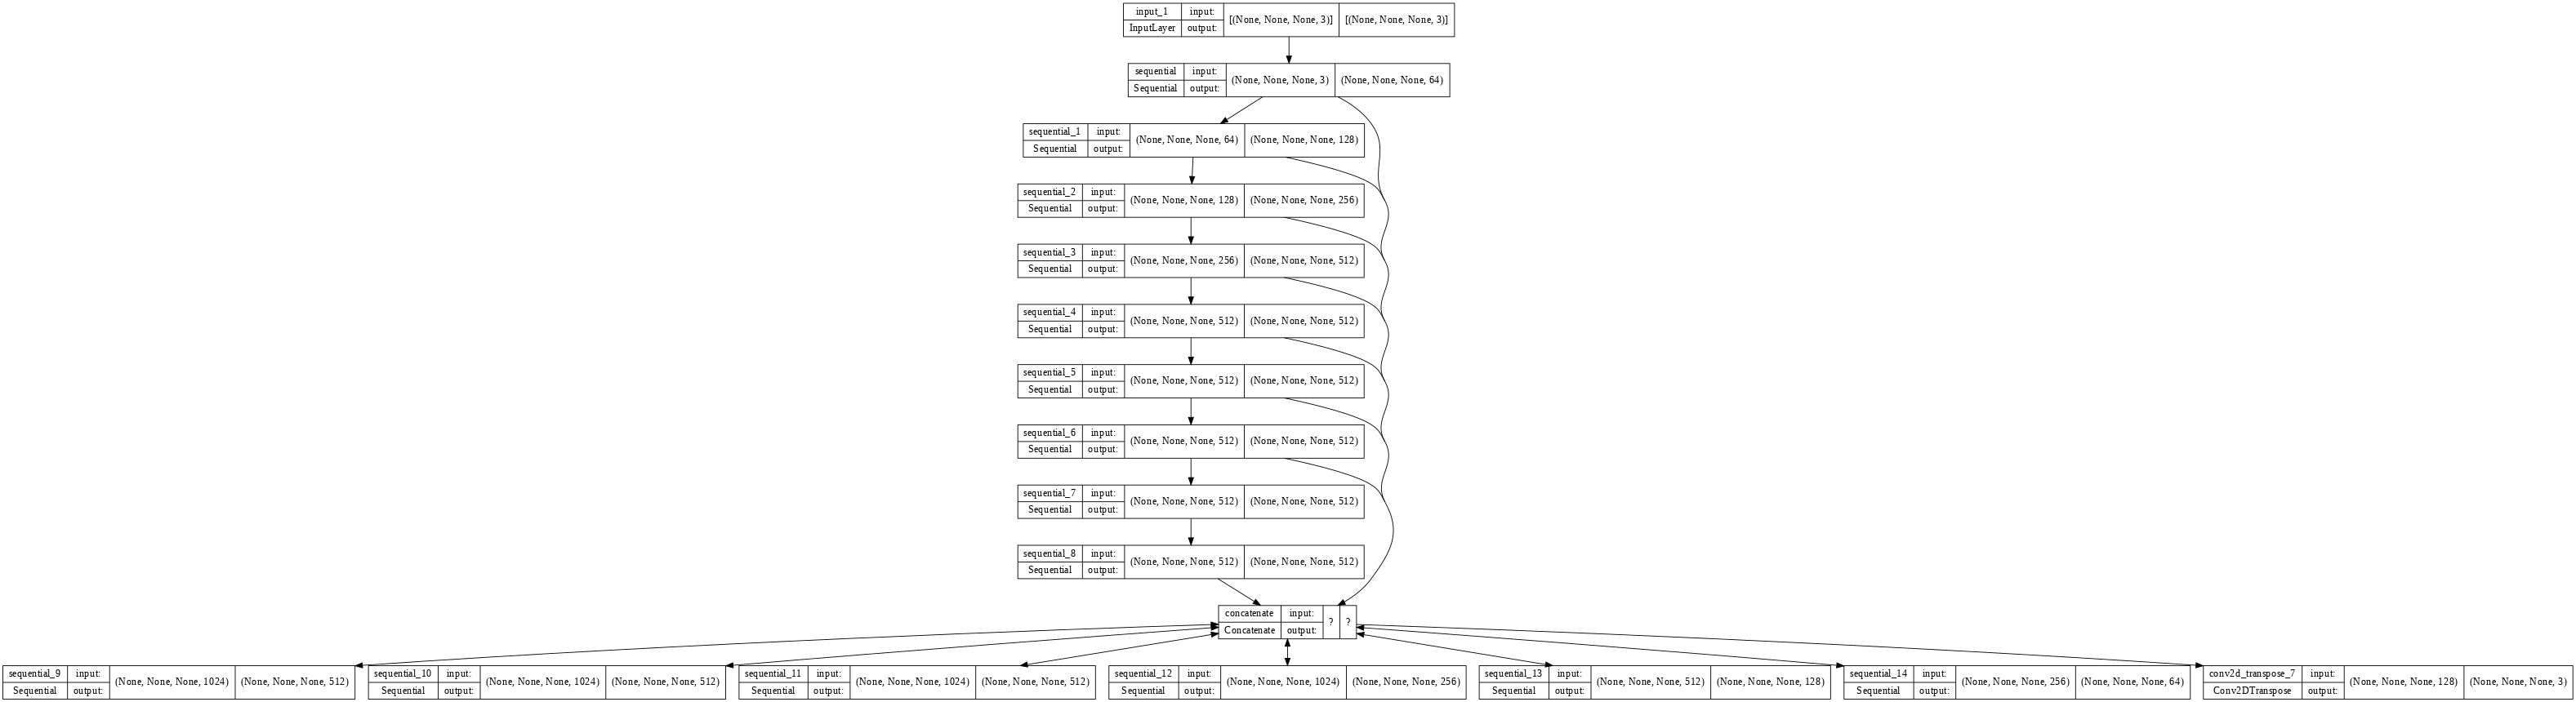

In [23]:
from tensorflow_examples.models.pix2pix import pix2pix

OUTPUT_CHANNELS = 3

# generator_g = Generator(OUTPUT_CHANNELS, norm_type="instancenorm")
# generator_f = Generator(OUTPUT_CHANNELS, norm_type="instancenorm")

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

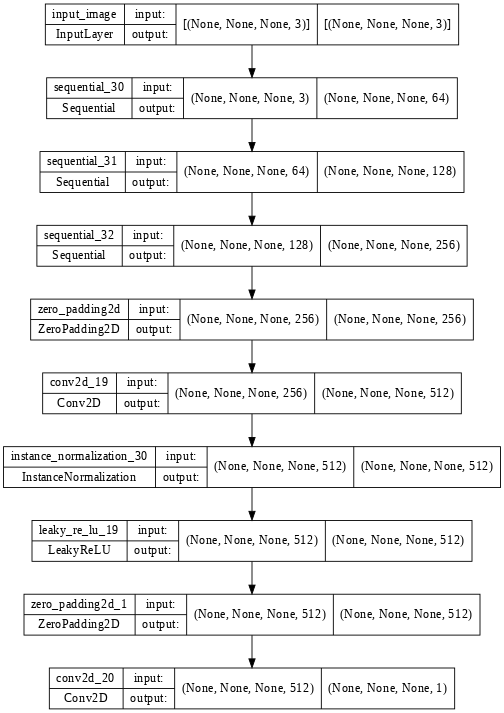

In [24]:
# discriminator_x = Discriminator(norm_type="instancenorm", target=False)
# discriminator_y = Discriminator(norm_type="instancenorm", target=False)

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

tf.keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

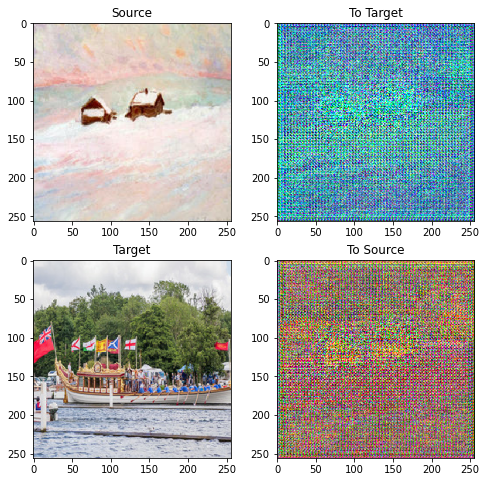

In [25]:
to_Source = generator_g(sample_A)
to_Target = generator_f(sample_A)

plt.figure(figsize=(8,8))
contrast = 8

imgs = [sample_A, to_Target, sample_B, to_Source]
title = ["Source", "To Target", "Target", "To Source"]

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i%2==0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
    
plt.show()

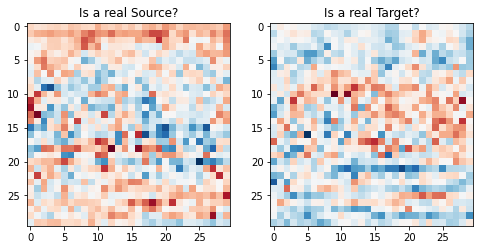

In [26]:
plt.figure(figsize=(8,8))

plt.subplot(121)
plt.title("Is a real Source?")
plt.imshow(discriminator_y(sample_B)[0, ..., -1], cmap="RdBu_r")

plt.subplot(122)
plt.title("Is a real Target?")
plt.imshow(discriminator_x(sample_B)[0, ..., -1], cmap="RdBu_r")

plt.show()

In [27]:
LAMBDA = 10

In [28]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [30]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [31]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [32]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [33]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [34]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest checkpoint restored!!")

Latest checkpoint restored!!


In [35]:
EPOCHS = 10

In [36]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [37]:
@tf.function 
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)    
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

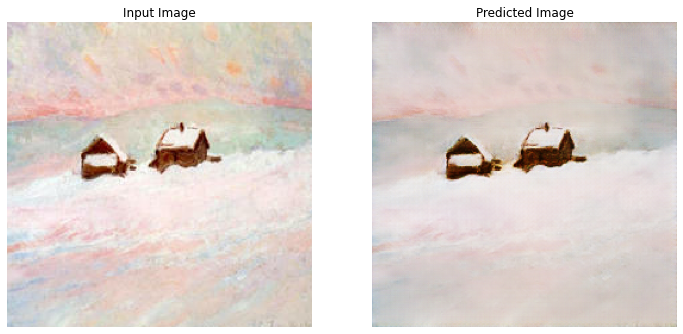

Time take for epoch 9 is 458.4596469402313 sec

..........................................

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((trainA, trainB)):
    train_step(image_x, image_y)
    if n%10 == 0:
      print('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_image) so that the progress of the model
  # is clearly visible.

  generate_images(generator_g, sample_A)
  if(epoch+1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} at {}".format(epoch+1, ckpt_save_path))

  print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time()-start))


In [ ]:
# Run the trained model on the test dataset
for inp in testA.take(5):
  generate_images(generator_g, inp)
